# EDA (Exploration Data Analysis)

In [2]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive')

  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'AI Dataset Sample/'

  !pip install fastai pydicom kornia fastcore==1.0.9 --upgrade --quiet
  
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  import os
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

  IN_COLAB = True
except:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'
  IN_COLAB = False

In [1]:
from fastai.basics import *
from fastai.medical.imaging import *

import pandas as pd
import os
import matplotlib.pyplot as plt

In [6]:
PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
# raw_folder = PATH_PREFIX + 'raw'
raw_folder = 'F:\Descargas\DICOMS'
organize_folder = PATH_PREFIX + 'organized'
preprocess_folder = PATH_PREFIX + 'preprocess'


Filename.........: F:\Descargas\DICOMS/01010000265254/ARIN1J7K5QQ7BeDIUIAP8PM4NVSG41D1DU1S970T5PVP84VGN999B
Storage type.....: 1.2.840.10008.5.1.4.1.1.1

Patient's name....: 1234, 
Patient id........: 1234
SeriesDescription.: RODILLA LAT
Body Part Examined: LOWER LIMB
Modality..........: CR
Study Date........: 20190117
Image size.......: 1794 x 1144, 4104672 bytes
Pixel spacing....: None
Slice location...: (missing)


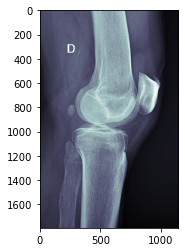

In [7]:
filename = raw_folder + '/01010000265254/DN6HRHRGK7HVUeB1BJMI58TIKKAG41D1DU1P8U02CDN8FSGKRC0FK'
# filename = organize_folder + '/CD/0/01010000265254.dcm'
dcm = dcmread(filename)

# Normal mode:
print()
print("Filename.........:", filename)
print("Storage type.....:", dcm.SOPClassUID)
print()

pat_name = dcm.PatientName
display_name = pat_name.family_name + ", " + pat_name.given_name
print("Patient's name....:", display_name)
print("Patient id........:", dcm.PatientID)
print("SeriesDescription.:", dcm.SeriesDescription)
print("Body Part Examined:", dcm.BodyPartExamined)
print("Modality..........:", dcm.Modality)
print("Study Date........:", dcm.StudyDate)

if 'PixelData' in dcm:
    rows = int(dcm.Rows)
    cols = int(dcm.Columns)
    print("Image size.......: {rows:d} x {cols:d}, {size:d} bytes".format(
        rows=rows, cols=cols, size=len(dcm.PixelData)))
    if 'PixelSpacing' in dcm:
        print("Pixel spacing....:", dcm.PixelSpacing)

# use .get() if not sure the item exists, and want a default value if missing
print("Slice location...:", dcm.get('SliceLocation', "(missing)"))

# plot the image using matplotlib
plt.imshow(dcm.pixel_array, cmap=plt.cm.bone)
plt.show()

## Raw Data EDA

In [8]:
df = pd.DataFrame.from_dicoms(
    get_files(raw_folder)
)
df.T

C', 'InstitutionName': 'ASEPEYO ALICANTE', 'ReferringPhysicianName': 'apps', 'StationName': 'DROC', 'StudyDescription': 'Rodilla AP y LAT', 'SeriesDescription': 'TOBILLO LAT MESA', 'OperatorsName': 'apps', 'ManufacturerModelName': 'Copyright(C) SEDECAL Corp', 'ReferencedSOPInstanceUID': '10.11.1247.1104.166.1128.201907021943410.1', 'DerivationDescription': 'RaimDicomCs 1.0.13.406 - dcmcjpeg v3.6.0 - Lossless JPEG compression, selection value 1, point transform 0, compression ratio 3.1316 [SYMPHONY]', 'AnatomicRegionSequence': [], 'DerivationCodeSequence': (0008, 0100) Code Value                          SH: '121327'
(0008, 0102) Coding Scheme Designator            SH: 'DCM'
(0008, 0104) Code Meaning                        LO: 'Full fidelity image', 'PatientName': '1234', 'PatientID': '1234', 'PatientBirthDate': '19761028', 'PatientSex': 'M', 'PatientWeight': None, 'PatientComments': '', 'BodyPartExamined': 'ANKLE', 'KVP': "48.0", 'SoftwareVersions': 'Version 4.13.7.6', 'ProtocolName': 

,0,1,2,3,4,5,6,7,8,9,...,1728,1729,1730,1731,1732,1733,1734,1735,1736,1737
,16,16,16,16,16,16,16,16,16,16,...,b'LAT ',b'AP',b'AP',b'LAT ',b'AP',b'LAT ',b'LAT ',b'AP',b'LAT ',b'AP'
SpecificCharacterSet,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,...,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100,ISO_IR 100
ImageType,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,...,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED,DERIVED
SOPClassUID,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,...,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1,1.2.840.10008.5.1.4.1.1.1
SOPInstanceUID,1216.1158.1243.113.1196.184.20190117113311.12,1216.1158.1243.113.1196.184.20190117113311.11,1216.1158.1243.113.1196.184.20190129103613.4,1216.1158.1243.113.1196.184.20190129103613.3,1216.1158.1243.113.1196.184.20190130113155.3,1216.1158.1243.113.1196.184.20190130113155.4,1216.1158.1243.113.1196.184.20190215174436.39,1216.1158.1243.113.1196.184.20190215174436.40,1216.1158.1243.113.1196.184.20190220113109.4,1216.1158.1243.113.1196.184.20190220113109.3,...,10.11.1247.1104.166.1128.202002200854250,10.11.1247.1104.166.1128.20200220085425,10.11.1247.1104.166.1128.20200221114806,10.11.1247.1104.166.1128.202002211148060,10.11.1247.1104.166.1128.20200221153633,10.11.1247.1104.166.1128.202002211536330,10.11.1247.1104.166.1128.202002211550170,10.11.1247.1104.166.1128.20200221155017,10.11.1247.1104.166.1128.202002211809540,10.11.1247.1104.166.1128.20200221180954
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
DateOfLastDetectorCalibration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TimeOfLastDetectorCalibration,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GridFocalDistance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MultiFieldOfViewDimensions,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


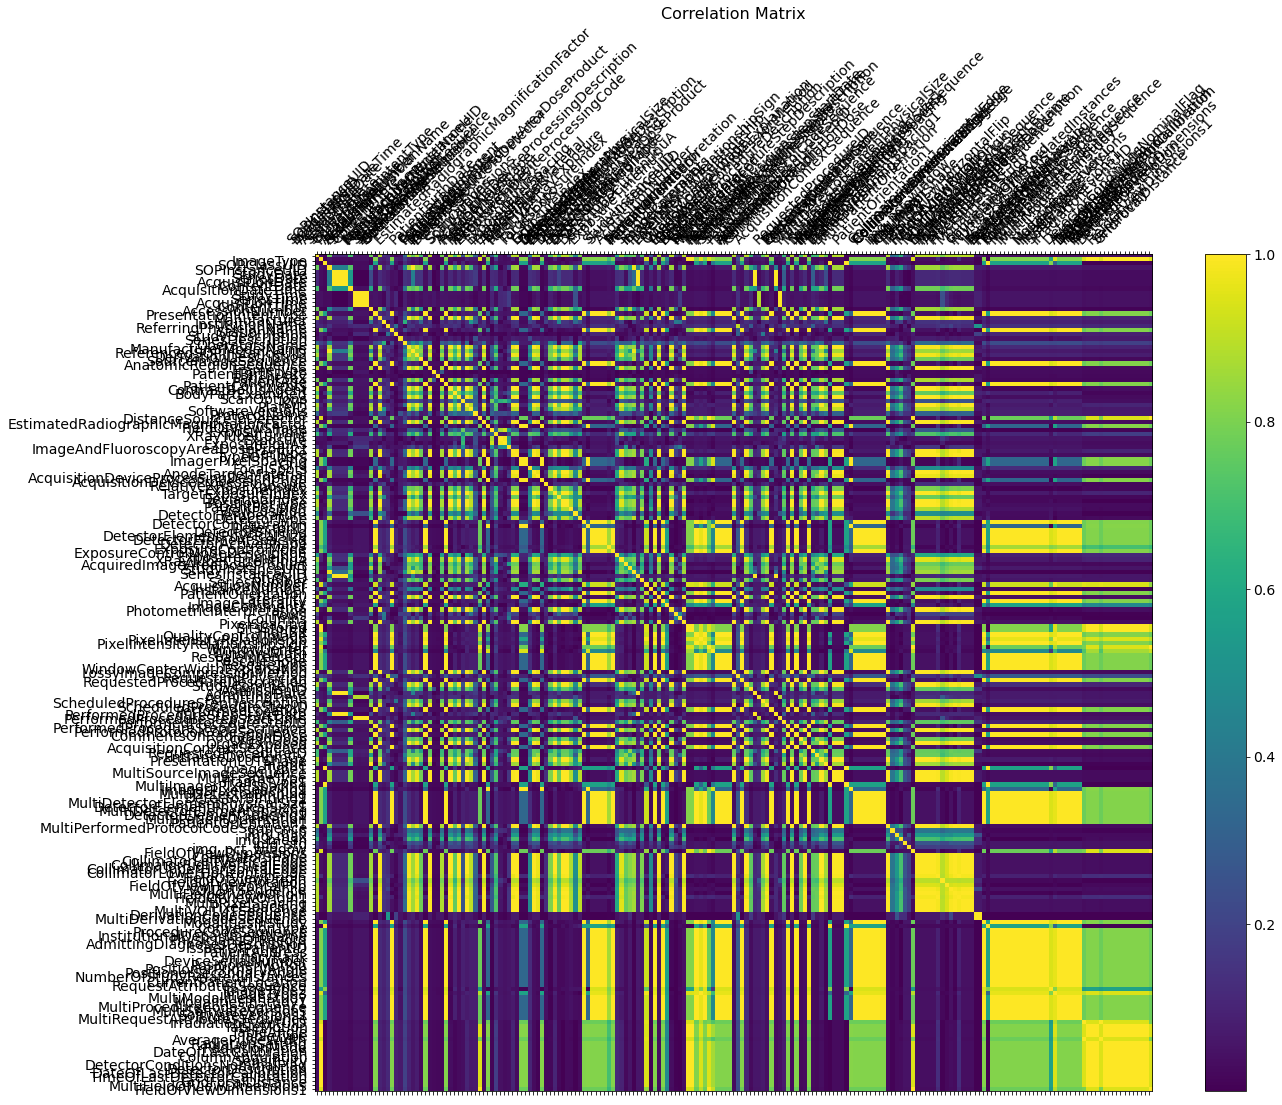

In [9]:
corr = df.astype('string').astype('category').apply(lambda x: x.cat.codes, axis=0).corr()

corr = corr.loc[corr.notnull().any(axis=0),corr.notnull().any(axis=1)].abs()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

In [10]:
repr_flds = [
    'SeriesDescription',
    'BodyPartExamined',
    'Modality',
    'StudyDescription',
    # 'ViewPosition',
    # 'AcquiredImageAreaDoseProduct'
]
display(df.pivot_table(values=['img_mean','img_std','img_max','img_min','PatientID'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min', 'img_std':'mean','PatientID':'count'}))

PatientID  \
SeriesDescription BodyPartExamined Modality StudyDescription                           
AMBAS MANOS       HAND             CR       Rodilla AP y LAT  : Derecho            2   
                                            Rodilla AP y LAT  : Izquierdo          1   
AMBAS MANOS OBL   HAND             CR       Rodilla AP y LAT  : Derecho            2   
                                            Rodilla AP y LAT  : Izquierdo          1   
AMBOS PIES        FOOT             CR       Rodilla AP y LAT  : Derecho            1   
...                                                                              ...   
TOBILLO AP MESA   ANKLE            CR       Rodilla AP y LAT  : Izquierdo          5   
TOBILLO LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Izquierdo          5   
TOBILLO LAT MESA  ANKLE            CR       Rodilla AP y LAT                       2   
                                            Rodilla AP y LAT  : Derecho            5   
                                            Rodilla AP y LAT  : Izquierdo          5   

                                                                           img_max  \
SeriesDescription BodyPartExamined Modality StudyDescription                         
AMBAS MANOS       HAND             CR       Rodilla AP y LAT  : Derecho       4095   
                                            Rodilla AP y LAT  : Izquierdo     4095   
AMBAS MANOS OBL   HAND             CR       Rodilla AP y LAT  : Derecho       4095   
                                            Rodilla AP y LAT  : Izquierdo     3833   
AMBOS PIES        FOOT             CR       Rodilla AP y LAT  : Derecho       4095   
...                                                                            ...   
TOBILLO AP MESA   ANKLE            CR       Rodilla AP y LAT  : Izquierdo     4095   
TOBILLO LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Izquierdo     4048   
TOBILLO LAT MESA  ANKLE            CR       Rodilla AP y LAT                  4095   
                                            Rodilla AP y LAT  : Derecho       4095   
                                            Rodilla AP y LAT  : Izquierdo     4095   

                                                                              img_mean  \
SeriesDescription BodyPartExamined Modality StudyDescription                             
AMBAS MANOS       HAND             CR       Rodilla AP y LAT  : Derecho    3090.066684   
                                            Rodilla AP y LAT  : Izquierdo  2052.287761   
AMBAS MANOS OBL   HAND             CR       Rodilla AP y LAT  : Derecho    2902.860117   
                                            Rodilla AP y LAT  : Izquierdo  3035.566416   
AMBOS PIES        FOOT             CR       Rodilla AP y LAT  : Derecho    2923.715894   
...                                                                                ...   
TOBILLO AP MESA   ANKLE            CR       Rodilla AP y LAT  : Izquierdo  3034.504096   
TOBILLO LAT       LOWER LIMB       CR       Rodilla AP y LAT  : Izquierdo  1061.043751   
TOBILLO LAT MESA  ANKLE            CR       Rodilla AP y LAT               1637.280724   
                                            Rodilla AP y LAT  : Derecho    3086.437727   
                                            Rodilla AP y LAT  : Izquierdo  3312.438502   

                                                                           img_min  \
SeriesDescription BodyPartExamined Modality StudyDescription                         
AMBAS MANOS       HAND             CR       Rodilla AP y LAT  : Derecho          0   
                                            Rodilla AP y LAT  : Izquierdo        0   
AMBAS MANOS OBL   HAND             CR       Rodilla AP y LAT  : Derecho          0   
                                            Rodilla AP y LAT  : Izquierdo      336   
AMBOS PIES        FOOT             CR       Rodilla AP y LAT  : Derecho          0   
...                                   

## Filtered Data EDA

In [11]:
# Transform metadata to DataFrame
df = pd.DataFrame.from_dicoms(
    get_files(organize_folder, extensions='.dcm')
)

In [12]:
repr_flds = ['BitsStored','PixelRepresentation']
display(df.pivot_table(values=['img_mean','img_max','img_min','PatientID'], index=repr_flds,
                   aggfunc={'img_mean':'mean','img_max':'max','img_min':'min','PatientID':'count'}))
display(df.pivot_table(values=['WindowCenter','WindowWidth', 'RescaleIntercept', 'RescaleSlope'], index=repr_flds,
                   aggfunc={'mean','max','min','std','median'}))

,,PatientID,img_max,img_mean,img_min
BitsStored,PixelRepresentation,,,,
12,0,277,4093,1297.893658,3


RescaleIntercept                        \
                                            max mean median  min  std   
BitsStored PixelRepresentation                                          
12         0                                0.0  0.0    0.0  0.0  0.0   

                               RescaleSlope                        \
                                        max mean median  min  std   
BitsStored PixelRepresentation                                      
12         0                            1.0  1.0    1.0  1.0  0.0   

                               WindowCenter                               \
                                        max    mean  median     min  std   
BitsStored PixelRepresentation                                             
12         0                         2048.0  2048.0  2048.0  2048.0  0.0   

                               WindowWidth                               
                                       max    mean  median     min  std  
BitsStored PixelRepresentation                                           
12         0                        4096.0  4096.0  4096.0  4096.0  0.0

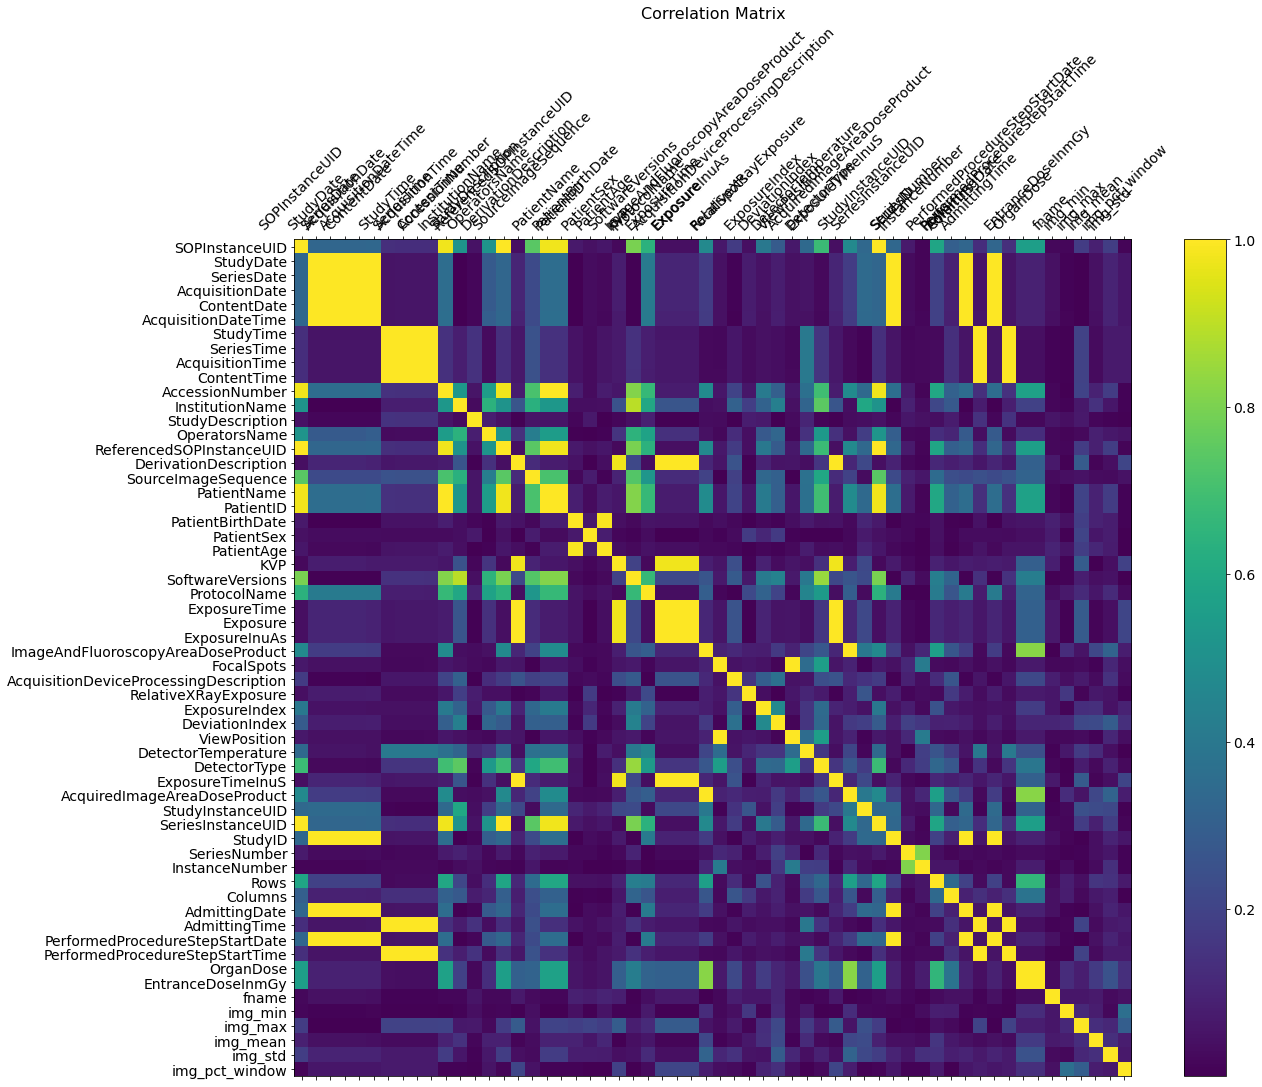

In [13]:
corr = df.astype('string').astype('category').apply(lambda x: x.cat.codes, axis=0).corr()

corr = corr.loc[corr.notnull().any(axis=0),corr.notnull().any(axis=1)].abs()

f = plt.figure(figsize=(19, 15))
plt.matshow(corr, fignum=f.number)
plt.xticks(range(corr.shape[1]), corr.columns, fontsize=14, rotation=45)
plt.yticks(range(corr.shape[1]), corr.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);
plt.show()

The DeviationIndex seems to be a potential features related to the `img_mean` and `img_std`